### Topic Modeling: Movie review

In [2]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from gensim import corpora, models

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import nltk
from nltk import FreqDist
import pandas as pd
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

# Import the wordcloud library
from wordcloud import WordCloud

C:\Users\Shashi\anaconda3\lib\site-packages\nltk\decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
C:\Users\Shashi\anaconda3\lib\site-packages\nltk\lm\counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Sequence, defaultdict
C:\Users\Shashi\anaconda3\lib\site-packages\nltk\lm\vocabulary.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Counter, Iterable


In [3]:
#Import Data 
df = pd.read_csv('movie-Review.csv')

In [4]:
import numpy as np
np.random.seed(500)

       text
class      
Neg    1000
Pos    1000


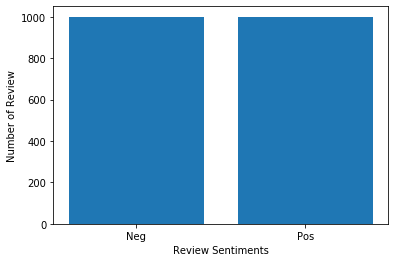

In [5]:
class_count=df.groupby('class').count()
print(class_count)
import matplotlib.pyplot as plt
plt.bar(class_count.index.values, class_count['text'])
plt.xlabel('Review Sentiments')
plt.ylabel('Number of Review')
plt.show()

In [6]:
#Remove number
import re # import all Regular expression functions
df['text']=[re.sub('\d','', i)for i in df['text']]
df.head(10)

<>:3: DeprecationWarning: invalid escape sequence \d
<>:3: DeprecationWarning: invalid escape sequence \d
<>:3: DeprecationWarning: invalid escape sequence \d
<ipython-input-6-53debfa22243>:3: DeprecationWarning: invalid escape sequence \d
  df['text']=[re.sub('\d','', i)for i in df['text']]


,class,text
0,Pos,films adapted from comic books have had plent...
1,Pos,every now and then a movie comes along from a...
2,Pos,you ve got mail works alot better than it des...
3,Pos,jaws is a rare film that grabs your atte...
4,Pos,moviemaking is a lot like being the general m...
5,Pos,on june a self taught idealistic ye...
6,Pos,apparently director tony kaye had a major b...
7,Pos,one of my colleagues was surprised when i tol...
8,Pos,after bloody clashes and independence won l...
9,Pos,the american action film has been slowly drow...


In [7]:
# Replace punctuations with a white space
import string
df['text']=[re.sub('[%s]' % re.escape(string.punctuation), ' ', i) for i in df['text']]
df.head(10)

,class,text
0,Pos,films adapted from comic books have had plent...
1,Pos,every now and then a movie comes along from a...
2,Pos,you ve got mail works alot better than it des...
3,Pos,jaws is a rare film that grabs your atte...
4,Pos,moviemaking is a lot like being the general m...
5,Pos,on june a self taught idealistic ye...
6,Pos,apparently director tony kaye had a major b...
7,Pos,one of my colleagues was surprised when i tol...
8,Pos,after bloody clashes and independence won l...
9,Pos,the american action film has been slowly drow...


In [8]:
#Convert into in lower case
df['text']=[i.lower() for i in df['text']]

In [9]:
# import pandas as pd 
import pandas as pd 
#Word Tokenization
import nltk # import package for tokenization
#nltk.download('punkt') # download all spporting function /files for NLTK package
from nltk.tokenize import word_tokenize
df['text_wt'] = [word_tokenize(i) for i in df['text']]
df.head()

,class,text,text_wt
0,Pos,films adapted from comic books have had plent...,"[films, adapted, from, comic, books, have, had..."
1,Pos,every now and then a movie comes along from a...,"[every, now, and, then, a, movie, comes, along..."
2,Pos,you ve got mail works alot better than it des...,"[you, ve, got, mail, works, alot, better, than..."
3,Pos,jaws is a rare film that grabs your atte...,"[jaws, is, a, rare, film, that, grabs, your, a..."
4,Pos,moviemaking is a lot like being the general m...,"[moviemaking, is, a, lot, like, being, the, ge..."


In [10]:
#To show the stop words
#nltk.download('stopwords') #download Stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
#Remove All Stop Word
df['text_SW'] = [[i for i in j if not i in stop_words] for j in df['text_wt']]# remove the word which is aviable in stopword libr
df.head()

,class,text,text_wt,text_SW
0,Pos,films adapted from comic books have had plent...,"[films, adapted, from, comic, books, have, had...","[films, adapted, comic, books, plenty, success..."
1,Pos,every now and then a movie comes along from a...,"[every, now, and, then, a, movie, comes, along...","[every, movie, comes, along, suspect, studio, ..."
2,Pos,you ve got mail works alot better than it des...,"[you, ve, got, mail, works, alot, better, than...","[got, mail, works, alot, better, deserves, ord..."
3,Pos,jaws is a rare film that grabs your atte...,"[jaws, is, a, rare, film, that, grabs, your, a...","[jaws, rare, film, grabs, attention, shows, si..."
4,Pos,moviemaking is a lot like being the general m...,"[moviemaking, is, a, lot, like, being, the, ge...","[moviemaking, lot, like, general, manager, nfl..."


In [11]:
#nltk.download('tagsets')
#nltk.help.upenn_tagset()# tagset documentation
#nltk.download('wordnet')
from collections import defaultdict #Default Dictionary is imported from collections
from nltk.corpus import wordnet as wn #the corpus reader wordnet is imported.
from nltk.tag import pos_tag
# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. 
#By default it is set to Noun
tag_map = defaultdict(lambda : wn.NOUN) #Dictionary is created where pos_tag (first letter) are the key values 
tag_map['J'] = wn.ADJ                   #whose values are mapped with the value 
tag_map['V'] = wn.VERB                  #from wordnet dictionary. We have taken the only first letter as 
tag_map['R'] = wn.ADV
# we will use it later in the loop.
#tag_map

In [12]:
#nltk.download('averaged_perceptron_tagger')
#lemmatization
from nltk.stem import WordNetLemmatizer 
 # Initializing WordNetLemmatizer()
lemmatizer = WordNetLemmatizer()

df['lemma']=[[lemmatizer.lemmatize(word,tag_map[tag[0]]) for word ,tag in pos_tag(i)] for i in df['text_SW']] 
df.head()

,class,text,text_wt,text_SW,lemma
0,Pos,films adapted from comic books have had plent...,"[films, adapted, from, comic, books, have, had...","[films, adapted, comic, books, plenty, success...","[film, adapt, comic, book, plenty, success, wh..."
1,Pos,every now and then a movie comes along from a...,"[every, now, and, then, a, movie, comes, along...","[every, movie, comes, along, suspect, studio, ...","[every, movie, come, along, suspect, studio, e..."
2,Pos,you ve got mail works alot better than it des...,"[you, ve, got, mail, works, alot, better, than...","[got, mail, works, alot, better, deserves, ord...","[get, mail, work, alot, good, deserves, order,..."
3,Pos,jaws is a rare film that grabs your atte...,"[jaws, is, a, rare, film, that, grabs, your, a...","[jaws, rare, film, grabs, attention, shows, si...","[jaw, rare, film, grab, attention, show, singl..."
4,Pos,moviemaking is a lot like being the general m...,"[moviemaking, is, a, lot, like, being, the, ge...","[moviemaking, lot, like, general, manager, nfl...","[moviemaking, lot, like, general, manager, nfl..."


In [13]:
 df['lemma2']= df['lemma'].apply(lambda x: ' '.join(x))

In [14]:
df['lemma2'].head()

0    film adapt comic book plenty success whether s...
1    every movie come along suspect studio every in...
2    get mail work alot good deserves order make fi...
3    jaw rare film grab attention show single image...
4    moviemaking lot like general manager nfl team ...
Name: lemma2, dtype: object

### Plot a bar graph of n most frequent words in the data.

In [15]:
# function to plot most frequent terms
def freq_words(x, terms = 20):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()

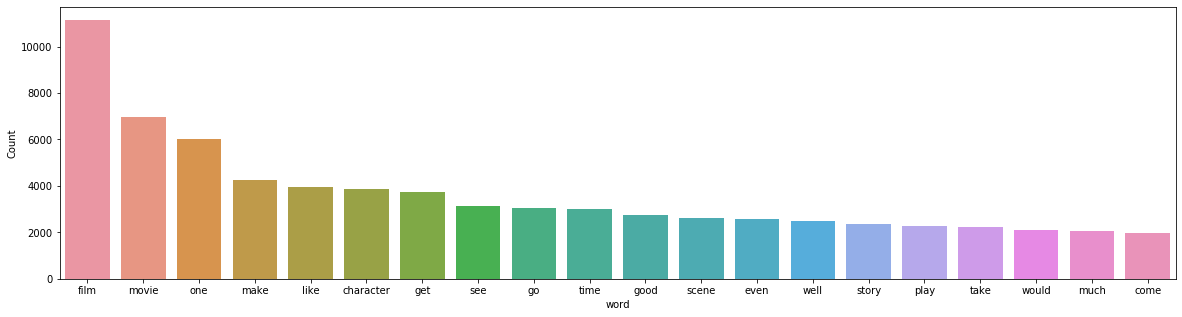

In [16]:
freq_words(df['lemma2'])

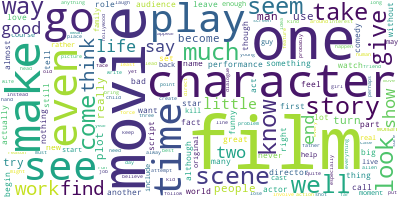

In [17]:

# Join the different processed titles together.
long_string = ','.join(list(df['lemma2'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

### Create the Dictionary and Corpus needed for Topic Modeling
The two main inputs to the LDA topic model are <br>
1.The dictionary(id2word) <br>
2.The corpus <br>

Next, we need to generate a document term frequency matrix to create an LDA model. The document term frequency matrix counts how frequently a term appears in a document. For that, first, we create a dictionary of documents using the "corpora.Dictionary()" method.

The "Dictionary()" function traverses each document and assigns a unique id to each unique token along with their counts.

Next, the dictionary is converted into a bag-of-words using the "doc2bow()" method. The result is a list of vectors equal to the number of documents. Each document vector has a series of tuples with token id and token frequency pair (word_id, word_frequency).


#### Method 1: Create Bag of words using Gensim Package

In [18]:
# Create Dictionary
id2word = corpora.Dictionary(df['lemma'])

# Create Corpus
texts = df['lemma']

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

#### Method 2: Create TF-IDF using Gensim Package

In [19]:
# Applying TF-IDF
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [20]:
#[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

### Building the Topic Model

In [21]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

### View the topics in LDA model

In [22]:
# Print the Keyword in the 10 topics
lda_model.print_topics()

[(0,
  '0.018*"vampire" + 0.008*"spice" + 0.006*"besson" + 0.006*"myers" + 0.005*"harrelson" + 0.005*"wrestle" + 0.005*"farrellys" + 0.005*"wcw" + 0.005*"austin" + 0.005*"osmosis"'),
 (1,
  '0.016*"film" + 0.011*"movie" + 0.007*"one" + 0.006*"effect" + 0.005*"like" + 0.005*"make" + 0.004*"special" + 0.004*"look" + 0.004*"even" + 0.004*"action"'),
 (2,
  '0.010*"jackie" + 0.008*"damme" + 0.008*"chan" + 0.008*"kong" + 0.007*"hong" + 0.006*"flubber" + 0.006*"jean" + 0.006*"li" + 0.006*"shakespeare" + 0.005*"chinese"'),
 (3,
  '0.010*"film" + 0.006*"one" + 0.005*"life" + 0.005*"story" + 0.005*"make" + 0.004*"love" + 0.004*"character" + 0.003*"find" + 0.003*"like" + 0.003*"man"'),
 (4,
  '0.018*"film" + 0.017*"movie" + 0.011*"one" + 0.009*"get" + 0.008*"like" + 0.008*"make" + 0.008*"character" + 0.006*"good" + 0.006*"go" + 0.006*"bad"')]

### Evaluation of Topic Modeling Performance

1. Compute Model Perplexity :A measure of how good the model is. lower the better  <br>
2.Coherence Score:The average /median of the pairwise word-similarity scores of the words in the topic

In [23]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=df['lemma'], dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.454916356709226

Coherence Score:  0.37154298734812813


### Visualize the topics-keywords

From the below output, the bubbles on the left-side represents a topic and larger the bubble, the more prevalent is that topic. 
The topic model will be good if the topic model has big, non-overlapping bubbles scattered throughout the chart.

In [24]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.220115 -0.009626       1        1  45.340611
3      0.147892 -0.140794       2        1  35.456848
1      0.152878  0.150628       3        1  17.600794
2     -0.267457  0.009918       4        1   1.054616
0     -0.253428 -0.010126       5        1   0.547137, topic_info=          Term          Freq         Total Category  logprob  loglift
423      movie   7541.000000   7541.000000  Default  30.0000  30.0000
698     effect    802.000000    802.000000  Default  29.0000  29.0000
97        film  10299.000000  10299.000000  Default  28.0000  28.0000
1683    action   1317.000000   1317.000000  Default  27.0000  27.0000
979      fight    501.000000    501.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
4347    austin     17.351841     29.324764   Topic5  -5.4004   4.6835
2257     spice     32.361893     76.321655   Topic5  -4.7771   4.3503
7515   wrestle     18.595762     36.639648   Topic5  -5.3312   4.5300
6670     shane      8.894868     25.102413   Topic5  -6.0686   4.1707
5851  princess      9.165619     65.103615   Topic5  -6.0386   3.2477

[343 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
1683       1  0.603212  action
1683       2  0.018210  action
1683       3  0.371032  action
1683       4  0.007588  action
621        1  0.750938   actor
...      ...       ...     ...
504        3  0.187943    year
921        1  0.202620   young
921        2  0.654618   young
921        3  0.142673   young
17542      4  0.922354     yun

[487 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 2, 3, 1])

### How to find the optimal number of topics for LDA?

In [25]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
  
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

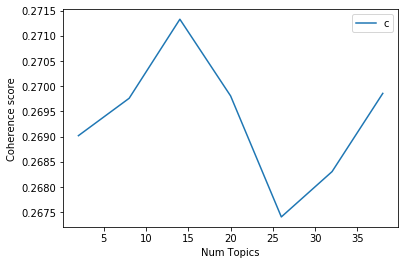

In [26]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=df['lemma'], start=2, limit=40, step=6)
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [27]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.269
Num Topics = 8  has Coherence Value of 0.2698
Num Topics = 14  has Coherence Value of 0.2713
Num Topics = 20  has Coherence Value of 0.2698
Num Topics = 26  has Coherence Value of 0.2674
Num Topics = 32  has Coherence Value of 0.2683
Num Topics = 38  has Coherence Value of 0.2699


### Finding the dominant topic in each sentence <br>
We find the topic number that has the highest percentage contribution in that document.

In [28]:
data=df['text']
optimal_model = model_list[3]
# Convert to list
data = list(df['lemma2'])
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.5660,"film, one, movie, make, go, get, see, time, li...",film adapt comic book plenty success whether s...
1,1,7.0,0.4182,"film, one, movie, character, get, make, time, ...",every movie come along suspect studio every in...
2,2,16.0,0.3659,"movie, film, one, make, character, even, story...",get mail work alot good deserves order make fi...
3,3,3.0,0.2482,"film, movie, get, go, one, good, even, see, wo...",jaw rare film grab attention show single image...
4,4,11.0,0.9974,"film, one, movie, like, character, get, make, ...",moviemaking lot like general manager nfl team ...
5,5,3.0,0.7576,"film, movie, get, go, one, good, even, see, wo...",june self teach idealistic yet pragmatic young...
6,6,10.0,0.5744,"film, character, one, make, movie, get, like, ...",apparently director tony kaye major battle new...
7,7,7.0,0.9862,"film, one, movie, character, get, make, time, ...",one colleague surprise told willing see betsy ...
8,8,17.0,0.9939,"film, one, make, like, movie, character, time,...",bloody clash independence lumumba refuse pande...
9,9,11.0,0.9807,"film, one, movie, like, character, get, make, ...",american action film slowly drown death sea as...


### Find the most representative document for each topic <br>
Sometimes just the topic keywords may not be enough to make sense of what a topic is about. So, to help with understanding the topic, we can find the documents a given topic has contributed to the most and infer the topic by reading that document. 

In [29]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9983,"film, one, movie, make, character, like, good,...",stand moment one soon forget giant green ogre ...
1,1.0,0.9958,"film, one, movie, character, like, make, get, ...",summer one racially charge novel john grisham ...
2,2.0,0.9976,"film, one, make, movie, character, like, go, g...",naturally core leon gast king fight fight than...
3,3.0,0.9981,"film, movie, get, go, one, good, even, see, wo...",martin scorsese film use intimidate reputation...
4,4.0,0.9975,"film, one, movie, make, go, get, see, time, li...",claus von bulow try kill wife sunny newport ma...
5,5.0,0.9974,"film, one, movie, get, make, like, see, go, sc...",set harlem great depression rival gangster fam...
6,6.0,0.6947,"film, one, movie, good, get, see, also, like, ...",see decent sport movie struggle break free oli...
7,7.0,0.9985,"film, one, movie, character, get, make, time, ...",get love disney matter serve guarantee success...
8,8.0,0.9982,"movie, film, like, see, make, one, even, much,...",inner flag half mast last year nick nite pulle...
9,9.0,0.9974,"movie, one, get, film, like, make, see, story,...",ingredient lose parrot try get home friend syn...


The tabular output above actually has 20 rows, one each for a topic. It has the topic number, the keywords, and the most representative document. The Perc_Contribution column is nothing but the percentage contribution of the topic in the given document.

### Topic distribution across documents

In [64]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
#df_dominant_topics.sort_values(by=['Dominant_Topic'], inplace=True)
df_dominant_topics.head(10)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,4.0,"film, one, movie, make, go, get, see, time, li...",67.0,0.0335
1.0,7.0,"film, one, movie, character, get, make, time, ...",37.0,0.0185
2.0,16.0,"movie, film, one, make, character, even, story...",41.0,0.0205
3.0,3.0,"film, movie, get, go, one, good, even, see, wo...",84.0,0.0420
4.0,11.0,"film, one, movie, like, character, get, make, ...",68.0,0.0340
5.0,3.0,"film, movie, get, go, one, good, even, see, wo...",18.0,0.0090
6.0,10.0,"film, character, one, make, movie, get, like, ...",6.0,0.0030
7.0,7.0,"film, one, movie, character, get, make, time, ...",149.0,0.0745
8.0,17.0,"film, one, make, like, movie, character, time,...",140.0,0.0700
9.0,11.0,"film, one, movie, like, character, get, make, ...",31.0,0.0155


### Frequency Distribution of Word Counts in Documents <br>
When working with a large number of documents, we want to know how big the documents are as a whole and by topic. Let’s plot the document word counts distribution.

Mean   : 2355.0
Median : 2182.0
Stdev   : 1035.0
1%ile    : 703.0
99%ile  : 5574.0


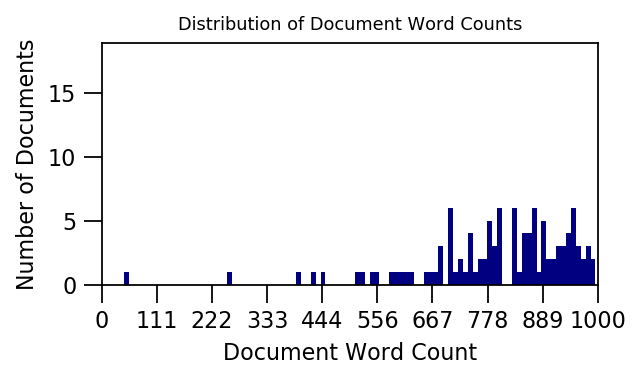

In [68]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(4,2), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
print( "Mean   : " + str(round(np.mean(doc_lens))))
print( "Median : " + str(round(np.median(doc_lens))))
print(  "Stdev   : " + str(round(np.std(doc_lens))))
print( "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
print( "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=8)
plt.xticks(np.linspace(0,1000,10))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=8))
plt.show()

Refrences:<br>
1.https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/ <br>
2.https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/ <br>
3.https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/